In [1]:
from google.colab import files
import io
import pandas as pd
import numpy as np

uploaded = files.upload()

myData = np.array([1, 4, 5, 8, 9, 10, 15, 16, 19, 25])

df = pd.read_csv(io.BytesIO(uploaded['letters.data']), header=None)

dfX = df.iloc[myData, 0:35]
dfY = df.iloc[myData, 35:]
dfY = dfY.iloc[::, myData]
y = dfY.values
X = dfX.values

import string
letters = list(np.array(list(string.ascii_uppercase))[myData])

Saving letters.data to letters.data


In [3]:
import copy
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors
import numpy as np
import time

from numba import cuda

import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
warnings.filterwarnings("ignore", message=".*GPU under-utilization due to low occupancy.*")

from numba.cuda.random import create_xoroshiro128p_states, init_xoroshiro128p_states, xoroshiro128p_uniform_float64


GPU_THREADS = 512 #HAS TO BE POWER OF 2



class SLP_gen_CUDA:
    def __init__(self, generationCountInThousands, mutationChance, valuesRange, multiplies, survives, maxIterations):

        self.maxIterations = maxIterations

        self.cudaBlockSize = generationCountInThousands
        self.generationCount = generationCountInThousands*GPU_THREADS
        print("gCount", self.generationCount)

        self.mutationChance = mutationChance
        self.valuesRange = valuesRange
        self.multiplies = multiplies
        self.survives = survives



    def fit(self, X, y):
        @cuda.jit
        def CUDA_zeroGeneration(randArr, currentGeneration, minValue, maxValue, inputCount):
            g = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x #generation
            p = cuda.blockIdx.y #perceptron
            a = (inputCount+1) * cuda.grid(1)
            diff = maxValue - minValue

            for i in range(inputCount+1):
                currentGeneration[g][p][i] = xoroshiro128p_uniform_float64(randArr, a) * diff + minValue

        start = time.time()

        self.dataLength = len(X)
        self.maxErrorCount = len(y)*len(y[0])
        self.X_CUDA = cuda.to_device(X)
        self.y_CUDA = cuda.to_device(y)

        self.perceptronCount = len(y[0])
        self.inputCount = len(X[0])

        self.stream2 = cuda.stream()
        self.rand1_CUDA = create_xoroshiro128p_states(self.generationCount * self.perceptronCount * (self.inputCount+1), seed=np.random.randint(1024**2), stream=self.stream2)
        # self.rand2_CUDA = create_xoroshiro128p_states(self.generationCount * self.perceptronCount * (self.inputCount+1), seed=np.random.randint(1024**2), stream=self.stream2)
        self.rand3_CUDA = create_xoroshiro128p_states(int(self.generationCount - (self.generationCount * self.survives))*2, seed=np.random.randint(1024**2), stream=self.stream2)

        self.currentGeneration_CUDA = cuda.device_array((self.generationCount, self.perceptronCount, self.inputCount+1), np.float64)
        self.inaccuracy_CUDA = cuda.device_array(self.generationCount, np.int64)
        self.bestFromGeneration_CUDA = cuda.device_array((int(self.generationCount * self.multiplies), self.perceptronCount, self.inputCount+1), np.float64)

        self.sortingArray_CUDA = cuda.device_array(self.generationCount, np.int32)
        self.sortingArrayOnes_CUDA = cuda.device_array((GPU_THREADS, self.cudaBlockSize), np.int32)
        self.sortingArrayZeros_CUDA = cuda.device_array((GPU_THREADS, self.cudaBlockSize), np.int32)
        self.sortingOnesSum_CUDA = cuda.device_array(GPU_THREADS, np.int32)
        self.sortingZerosSum_CUDA = cuda.device_array(GPU_THREADS, np.int32)
        self.sortingOnesPrefixSum_CUDA = cuda.device_array(GPU_THREADS, np.int32)
        self.sortingZerosPrefixSum_CUDA = cuda.device_array(GPU_THREADS, np.int32)


        self.stream2.synchronize()
        CUDA_zeroGeneration[(self.cudaBlockSize, self.perceptronCount), GPU_THREADS](self.rand1_CUDA, self.currentGeneration_CUDA, self.valuesRange[0], self.valuesRange[1], self.inputCount)

        dataToAnimate = []

        cuda.synchronize()
        end = time.time()
        print("allocation time:",end - start)
        self.error = []
        for i in range(self.maxIterations):
            error = self.oneIteration()
            self.error.append(error)
            dataToAnimate.append(self.bestFromGeneration_CUDA[0].copy_to_host())
            print("iter",i, error)
            if error == 0:
                break

        output = SLP()
        best = self.bestFromGeneration_CUDA[0].copy_to_host()
        output.saveLearningAnimation(X, y, letters, dataToAnimate, self.generationCount)
        output.error = self.error
        return output


    def oneIteration(self):
        @cuda.jit
        def CUDA_initSortingArray(sortingArray, sortingOnesSum, sortingZerosSum, inaccuracy):
            g = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
            sortingArray[g] = g
            inaccuracy[g] = 0


        @cuda.jit
        def CUDA_measureInaccuracy(X, y, inputCount, blockCount, dataLength, perceptronCount, currentGeneration, inaccuracy):
            t = cuda.threadIdx.x
            perceptronOut = 0
            for i in range(blockCount):
                g = t + cuda.blockDim.x * i #generation
                for x in range(dataLength):
                    for p in range(perceptronCount):
                        perceptronOut = currentGeneration[g][p][0]
                        for i in range(inputCount):
                            perceptronOut += currentGeneration[g][p][i+1] * X[x][i]
                        if (perceptronOut < 0 and y[x][p] == 1) or (perceptronOut >= 0 and y[x][p] == -1):
                            inaccuracy[g] += 1



        @cuda.jit
        def CUDA_sortByMask(inaccuracy, sortingArray, sortingArrayOnes, sortingArrayZeros, sortingOnesSum, sortingZerosSum, mask, loops):
            t = cuda.threadIdx.x

            sortingZerosSum[t] = 0
            sortingOnesSum[t] = 0

            for i in range(t*loops, (t+1)*loops):
                if (inaccuracy[sortingArray[i]] & mask) == 0:
                    sortingArrayZeros[t][sortingZerosSum[t]] = sortingArray[i]
                    sortingZerosSum[t] += 1

                else:
                    sortingArrayOnes[t][sortingOnesSum[t]] = sortingArray[i]
                    sortingOnesSum[t] += 1


        @cuda.jit
        def CUDA_scanSweep(sortingOnesSum, sortingZerosSum, sortingOnesPrefixSum, sortingZerosPrefixSum, zerosCount, GPU_THREADS):
            i = 1
            t = (cuda.threadIdx.x+1) * 2
            a = cuda.threadIdx.x + cuda.blockDim.x * cuda.threadIdx.y
            gridSize = GPU_THREADS


            sortingOnesPrefixSum[a] = sortingOnesSum[a]
            sortingZerosPrefixSum[a] = sortingZerosSum[a]
            cuda.syncthreads()


            for _ in range(9):
                if t <= gridSize:
                    if cuda.threadIdx.y == 1:
                        sortingOnesPrefixSum[t-1] += sortingOnesPrefixSum[t-1-i]
                    else:
                        sortingZerosPrefixSum[t-1] += sortingZerosPrefixSum[t-1-i]
                i <<= 1
                t <<= 1
                cuda.syncthreads()

            if a == 0:
                zerosCount[0] = sortingZerosPrefixSum[gridSize-1]
                # print("zeros", sortingZerosPrefixSum[gridSize-1])
                sortingOnesPrefixSum[gridSize-1] = 0
                sortingZerosPrefixSum[gridSize-1] = 0
            cuda.syncthreads()

            for _ in range(10):
                if t <= gridSize:
                    if cuda.threadIdx.y == 1:
                        temp = sortingOnesPrefixSum[t-1-i]
                        sortingOnesPrefixSum[t-1-i] = sortingOnesPrefixSum[t-1]
                        sortingOnesPrefixSum[t-1] += temp
                    else:
                        temp = sortingZerosPrefixSum[t-1-i]
                        sortingZerosPrefixSum[t-1-i] = sortingZerosPrefixSum[t-1]
                        sortingZerosPrefixSum[t-1] += temp
                i >>= 1
                t >>= 1
                cuda.syncthreads()

        @cuda.jit
        def CUDA_moveToArray(sortingOnesSum, sortingZerosSum, sortingArrayOnes, sortingArrayZeros, sortingOnesPrefixSum, sortingZerosPrefixSum, sortingArray, zerosCount):
            t = cuda.threadIdx.x
            start = sortingZerosPrefixSum[t]
            count = sortingZerosSum[t]

            for i in range(count):
                sortingArray[i+start] = sortingArrayZeros[t][i]
                # print("0", i+start)

            start = sortingOnesPrefixSum[t] + zerosCount[0]
            count = sortingOnesSum[t]

            for i in range(count):
                sortingArray[i+start] = sortingArrayOnes[t][i]
                # print("1", i+start, zerosCount[0])


        @cuda.jit
        def CUDA_copyBest(currentGeneration, bestFromGeneration, sortingArray, count):
            p = cuda.blockIdx.x #perceptron
            v = cuda.blockIdx.y #value

            for i in range(cuda.threadIdx.x, count, cuda.gridDim.x):
                bestFromGeneration[i][p][v] = currentGeneration[sortingArray[i]][p][v]

        #TODO inversed mutationChance
        @cuda.jit
        def CUDA_mixAndMutateGenes(bestFromGeneration, currentGeneration, sortingArray, mutationChance, minValue, diffValue, survivesCount, multipliesCount, generationCount, perceptronCount, inputCount, rand1, rand2, rand3, test):
            firstParentThresholdPoint = (1. - mutationChance) / 2

            for i in range(cuda.threadIdx.x, generationCount-survivesCount, cuda.blockDim.x):
                indexToFill = sortingArray[i+survivesCount]
                if test == indexToFill:
                    print("ERROR", cuda.threadIdx.x, test, sortingArray[i+survivesCount], i+survivesCount)
                firstParent = int(xoroshiro128p_uniform_float64(rand3, cuda.threadIdx.x) * survivesCount)
                secondParent = int(xoroshiro128p_uniform_float64(rand3, 1) * survivesCount)
                for p in range(perceptronCount):
                    for v in range(inputCount+1):
                        randScalar = xoroshiro128p_uniform_float64(rand1, cuda.threadIdx.x)
                        if  randScalar < mutationChance:
                            currentGeneration[indexToFill][p][v] = xoroshiro128p_uniform_float64(rand2, cuda.threadIdx.x) * diffValue + minValue
                        elif randScalar < firstParentThresholdPoint:
                            currentGeneration[indexToFill][p][v] = bestFromGeneration[firstParent][p][v]
                        else:
                            currentGeneration[indexToFill][p][v] = bestFromGeneration[secondParent][p][v]


        def testSortingArray(f):
            for i in range(self.generationCount):
                for j in range(i+1, self.generationCount):
                    if self.sortingArray_CUDA[i] == self.sortingArray_CUDA[j]:
                        print("sARReRR", f)
                        return

        def testZerosOnesArr(f):
            all = []
            for i in range(GPU_THREADS):
                for j in range(self.sortingOnesSum_CUDA[i]):
                    all.append(self.sortingArrayOnes_CUDA[j])

                for j in range(self.sortingZerosSum_CUDA[i]):
                    all.append(self.sortingArrayZeros_CUDA[j])

            for i in range(len(all)):
                for j in range(i+1, len(all)):
                    if all[i] == all[j]:
                        print("OZeRR", f)
                        return



        # self.rand3_CUDA = create_xoroshiro128p_states(int(self.generationCount - (self.generationCount * self.survives))*2, seed=np.random.randint(1024**2), stream=self.stream2)
        # self.rand2_CUDA = create_xoroshiro128p_states(self.generationCount * self.perceptronCount * (self.inputCount+1), seed=np.random.randint(1024**2), stream=self.stream2)
        # self.rand1_CUDA = create_xoroshiro128p_states(self.generationCount * self.perceptronCount * (self.inputCount+1), seed=np.random.randint(1024**2), stream=self.stream2)
        # print("  f1")

        CUDA_initSortingArray[self.cudaBlockSize, GPU_THREADS](self.sortingArray_CUDA, self.sortingOnesSum_CUDA, self.sortingZerosSum_CUDA, self.inaccuracy_CUDA)


        CUDA_measureInaccuracy[1, GPU_THREADS](self.X_CUDA, self.y_CUDA, self.inputCount, self.cudaBlockSize, self.dataLength, self.perceptronCount, self.currentGeneration_CUDA, self.inaccuracy_CUDA)


        zerosCount = cuda.device_array(1, np.int32)


        sortCount = 0
        mask = 1
        for i in range(32):
            if mask & self.maxErrorCount != 0:
                sortCount = i
            mask <<= 1
        sortCount += 1 #!!!!!!!!

        mask = 1
        for i in range(sortCount):
            # print("\n\n")
            CUDA_sortByMask[1, GPU_THREADS](self.inaccuracy_CUDA, self.sortingArray_CUDA, self.sortingArrayOnes_CUDA, self.sortingArrayZeros_CUDA, self.sortingOnesSum_CUDA, self.sortingZerosSum_CUDA, mask, self.cudaBlockSize)

            CUDA_scanSweep[1, (GPU_THREADS//2, 2)](self.sortingOnesSum_CUDA, self.sortingZerosSum_CUDA, self.sortingOnesPrefixSum_CUDA, self.sortingZerosPrefixSum_CUDA, zerosCount, GPU_THREADS)

            # print("zeros", zerosCount[0])

            CUDA_moveToArray[1, GPU_THREADS](self.sortingOnesSum_CUDA, self.sortingZerosSum_CUDA, self.sortingArrayOnes_CUDA, self.sortingArrayZeros_CUDA, self.sortingOnesPrefixSum_CUDA, self.sortingZerosPrefixSum_CUDA, self.sortingArray_CUDA, zerosCount)

            mask <<= 1

        cuda.synchronize()
        # print("  f2")

        CUDA_copyBest[(self.perceptronCount, self.inputCount), GPU_THREADS]( self.currentGeneration_CUDA, self.bestFromGeneration_CUDA, self.sortingArray_CUDA, int(self.generationCount* self.multiplies))

        # print("   best", self.inaccuracy_CUDA[self.sortingArray_CUDA[0]])
        # cuda.synchronize()
        # print("\n\nsortingArray")
        # for i in range(self.generationCount):
        #     print(self.sortingArray_CUDA[i])
        CUDA_mixAndMutateGenes[1, GPU_THREADS](self.bestFromGeneration_CUDA, self.currentGeneration_CUDA, self.sortingArray_CUDA, self.mutationChance, self.valuesRange[0], self.valuesRange[1]-self.valuesRange[0], int(self.generationCount* self.survives), int(self.generationCount* self.multiplies), self.generationCount, self.perceptronCount, self.inputCount, self.rand1_CUDA, self.rand1_CUDA, self.rand3_CUDA, self.sortingArray_CUDA[0])


        cuda.synchronize()
        # print("  f3")
        return self.inaccuracy_CUDA[self.sortingArray_CUDA[0]]




class Perceptron:
    def __init__(self, elements, T, w = [], bias = None, name = None):
        self.elements = elements
        self.T = T
        self.name = name
        self.error = None
        if len(w) == 0:
            self.w = [0 for i in range(elements)]
        else:
            self.w = w
        if bias == None:
            self.bias = 0
        else:
            self.bias = bias

    def __str__(self):
        out = ""
        for i in range(self.elements):
            out += "w"+str(i)+": "+str(self.w[i]) + " "
        return "(b:" + out + ")"

    def addInput(self, w = None):
        self.elements += 1
        if w == None:
            self.w.append(0)
        else:
            self.w.append(w)

    def out(self, values):
        I = sum([values[i]*self.w[i] for i in range(self.elements)])
        I += self.bias
        if I >= self.T:
            return 1
        else:
            return -1

    def printW(self):
        print("bias: "+str(self.bias))
        for i in range(self.elements):
            print("w"+str(i)+": "+str(self.w[i]))

    def learn(self, values, expected, n, maxIterations = 10000):
        errorOccured = True
        iterations = 0
        errorOut = []
        while errorOccured:
            errorCount = 0
            errorOccured = False
            for v,e in zip(values, expected):
                error = e - self.out(v)
                if not error == 0:
                    errorOccured = True
                    errorCount += 1
                    for j in range(self.elements):
                        self.w[j] = self.w[j]+v[j]*n*error
                    self.bias = self.bias+n*error
            iterations += 1
            errorOut.append(errorCount)
            if iterations == maxIterations:
                return errorOut
        return errorOut

class SLP:
    def __init__(self, eta = 0.05, n_iter = 10, random_state = 1):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, df, categoryAcceptors = None ,keyColumn = None):
        if type(categoryAcceptors) != None:
            self.categories = [i for i in range(len(df))]
            self.categoryAcceptors = categoryAcceptors.values
            self.data = df.values
            self.inputs = len(self.data[0])
        elif type(keyColumn) == int:
            self.categories = df.iloc[::, keyColumn].unique()
            temp = df.iloc[::, keyColumn].values
            self.categoryAcceptors = [np.where(temp == i, 1, -1) for i in self.categories]
            self.data = df.drop(df.columns[keyColumn], axis=1).values
            self.inputs = len(self.data[0])
        else:
            self.categories = keyColumn.unique()
            self.categoryAcceptors = [np.where(keyColumn == i, 1, -1) for i in self.categories]
            self.data = df.values
            self.inputs = len(self.data[0])

        learningErr = []
        self.perceptrons = [Perceptron(self.inputs, 0, name=v) for v in self.categories]
        for p, a in zip(self.perceptrons, self.categoryAcceptors):
            learningErr.append(p.learn(self.data, a, self.eta, self.n_iter))

        learningErrMaxLength = max([len(i) for i in learningErr])
        learningErr = [i for i in learningErr if i.extend([0] * (learningErrMaxLength-len(i))) == None]
        self.error = [0] * learningErrMaxLength
        for l in learningErr:
            for i, l_2 in enumerate(l):
                self.error[i] += l_2

    def set(self, values):
        self.inputs = len(values[0])-1
        self.perceptrons = [Perceptron(self.inputs, 0, bias=v[0], w=v[1:]) for v in values]

    def predict(self, X):
        try:
            some_object_iterator = iter(X[0])
        except TypeError as te:
            return [p.out(X) for p in self.perceptrons]
        else:
            return [[p.out(i) for i in X] for p in self.perceptrons]

    def misclassified(self, X, y):
        predicion = self.predict(X)
        missclasifications = sum([len([1 for v1,v2 in zip(a1, a2) if not v1 == v2]) for a1,a2 in zip(predicion, y)])
        return missclasifications


    def show(X):
        fig = plt.figure(figsize=(10, 5))
        out = [[0 for _ in range(5)] for _ in range(7)]
        cmap = plt.cm.gray_r

        for k, x in enumerate(X):
            for i in range(7):
                for j in range(5):
                    out[i][j] = x[j+5*i]

            fig.add_subplot(2, 5, k+1)
            plt.imshow(out, cmap=cmap)
        plt.show()

    def missclasificationGraph(self, X, y, axis, title):
        data = np.array(self.predict(X))
        misclassified = self.misclassified(X, y)

        for i,(d,c) in enumerate(zip(data, y)):
            for j,(d_2,c_2) in enumerate(zip(d,c)):
                if d_2 == -1 and c_2 == 1:
                    data[i][j] = 0
                if d_2 == 1 and c_2 == -1:
                    data[i][j] = 2
        data+=1

        values = [0, 1, 2, 3]
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#FFFFFF","#8080FF", "#00003A", "#FF00FF"])

        fig, ax = plt.subplots(figsize=(7,7))
        p = plt.imshow(data, cmap=cmap, vmin=min(values), vmax=max(values))
        cBar = plt.colorbar(p, location='right',fraction= 0.0838, aspect=4.1, drawedges=True, ticks=values, values=values)
        cBar.ax.set_yticklabels(['(-1): correct', '(-1): misclassified', '( 1): correct', '( 1): misclassified'])
        cBar.outline.set_linewidth(1.5)
        cBar.dividers.set_linewidth(1.5)
        plt.xlabel('LETTERS',)
        plt.ylabel('PERCEPTRONS')
        y_pos = np.arange(len(axis))
        plt.xticks(y_pos, axis, weight = 'bold')
        plt.yticks(y_pos, axis, weight = 'bold')
        plt.title(title, fontsize=18)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5)
        plt.figtext(0.25, 0.12, "misclassified: "+str(misclassified), wrap=True, horizontalalignment='center', fontsize=14)
        plt.show()

    def saveLearningAnimation(self, X, y, axis, percData, generationCount):
        values = [0, 1, 2, 3]
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#FFFFFF","#8080FF", "#00003A", "#FF00FF"])

        title = "net generation " + str(0) + ": predict(X)"
        fig, ax = plt.subplots(figsize=(9,7))
        self.set(percData[0])
        data = np.array(self.predict(X))
        plt.xlabel('LETTERS',)
        plt.ylabel('PERCEPTRONS')
        y_pos = np.arange(len(axis))
        plt.xticks(y_pos, axis, weight = 'bold')
        plt.yticks(y_pos, axis, weight = 'bold')
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5)
        # plt.figtext(0.25, 0.12, "misclassified: "+str(misclassified), wrap=True, horizontalalignment='center', fontsize=14)
        p = plt.imshow(data, cmap=cmap, vmin=min(values), vmax=max(values))
        cBar = plt.colorbar(p, location='right',fraction= 0.0838, aspect=4.1, drawedges=True, ticks=values, values=values)
        cBar.ax.set_yticklabels(['(-1): correct', '(-1): misclassified', '( 1): correct', '( 1): misclassified'])
        cBar.outline.set_linewidth(1.5)
        cBar.dividers.set_linewidth(1.5)
        plt.title(title, fontsize=18)
        text = plt.figtext(0.85, 0.08, "misclassified: ", wrap=True, horizontalalignment='center', fontsize=14)
        plt.figtext(0.85, 0.04, "gen. count: "+str(generationCount), wrap=True, horizontalalignment='center', fontsize=14)
        fig.tight_layout()

        def anim(iteration):
            title = "net generation " + str(iteration) + ": predict(X)"
            self.set(percData[iteration])
            data = np.array(self.predict(X))
            misclassified = self.misclassified(X, y)

            for i,(d,c) in enumerate(zip(data, y)):
                for j,(d_2,c_2) in enumerate(zip(d,c)):
                    if d_2 == -1 and c_2 == 1:
                        data[i][j] = 0
                    if d_2 == 1 and c_2 == -1:
                        data[i][j] = 2
            data+=1

            p = plt.imshow(data, cmap=cmap, vmin=min(values), vmax=max(values))
            plt.title(title, fontsize=18)
            text.set(text="misclassified: "+str(misclassified))
            return p

        ani = animation.FuncAnimation(fig, anim, frames=len(percData), interval=800)
        f = r"learningAnim.gif"
        writergif = animation.PillowWriter(fps=1)
        ani.save(f, writer=writergif)


    def damage(X, percent, seed = 1):
        rgen = np.random.RandomState(seed)
        result = np.array(X)
        count = int(X.shape[1]*percent/100)
        for index_example in range(len(X)):
            order = np.sort(rgen.choice(X.shape[1], count, replace=False))
            for index_pixel in order:
                result[index_example][index_pixel]*=-1
        return result






gCount 65536
allocation time: 8.401894807815552
iter 0 20
iter 1 17
iter 2 14
iter 3 11
iter 4 9
iter 5 7
iter 6 6
iter 7 6
iter 8 6
iter 9 3
iter 10 3
iter 11 3
iter 12 3
iter 13 3
iter 14 3
iter 15 3
iter 16 3
iter 17 3
iter 18 3
iter 19 2
iter 20 2
iter 21 2
iter 22 2
iter 23 2
iter 24 2
iter 25 2
iter 26 2
iter 27 2
iter 28 1
iter 29 1
iter 30 1
iter 31 1
iter 32 1
iter 33 1
iter 34 1
iter 35 1
iter 36 1
iter 37 1
iter 38 1
iter 39 1
iter 40 1
iter 41 1
iter 42 1
iter 43 1
iter 44 1
iter 45 1
iter 46 1
iter 47 1
iter 48 1
iter 49 1
iter 50 1
iter 51 1
iter 52 1
iter 53 1
iter 54 1
iter 55 1
iter 56 0


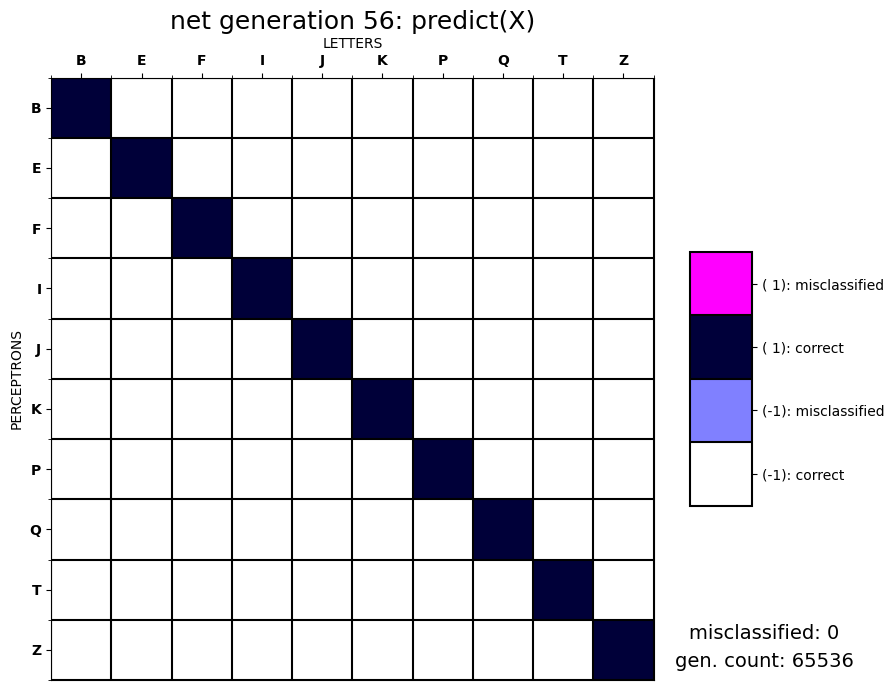

In [4]:
netGen = SLP_gen_CUDA(128, 0.05, (-1, 1), 0.2, 0.1, 200)
net = netGen.fit(X, y)


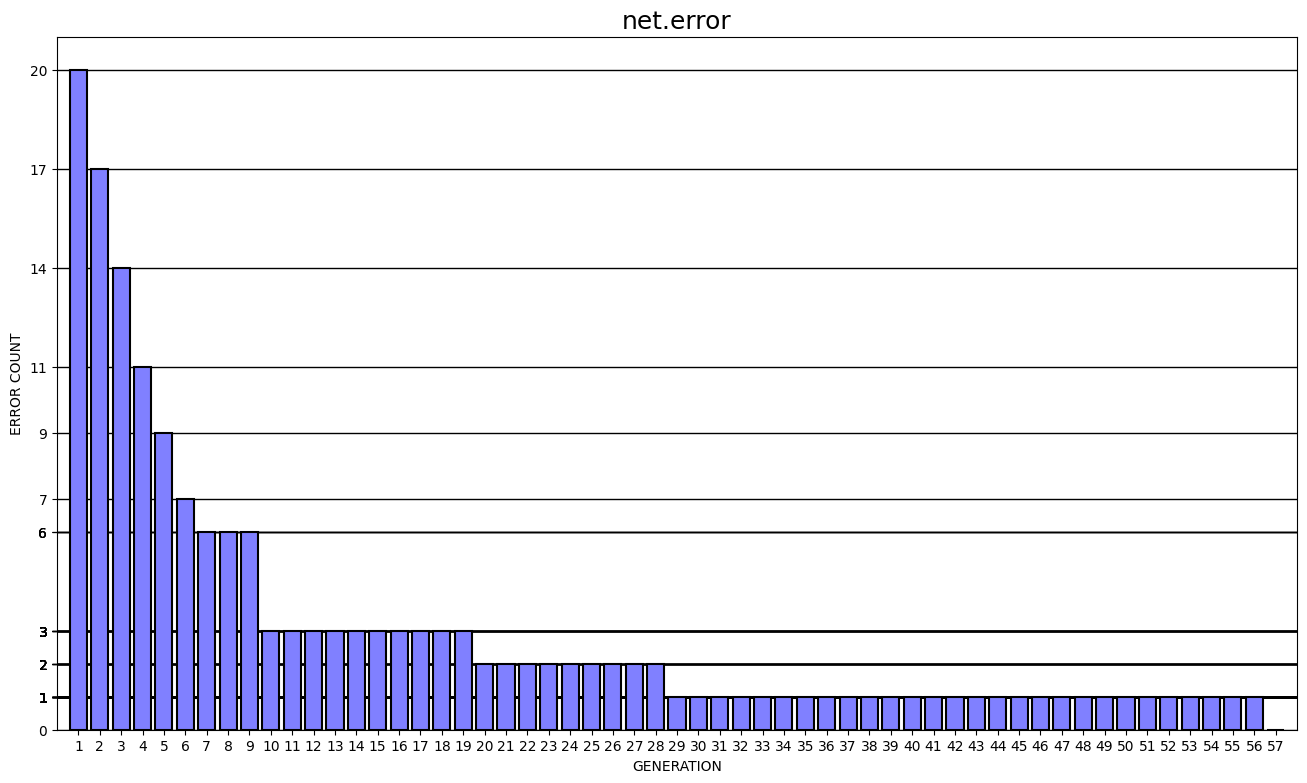

In [5]:
fig, ax = plt.subplots(figsize=(16,9))

ax.bar(list(range(1, len(net.error)+1)), net.error, color="#8080FF", align='center', width=0.8, edgecolor="#000000", linewidth=1.5, zorder=3)

ax.set(xlim=(0, len(net.error)+1), xticks=np.arange(1, len(net.error)+1),
       ylim=(0, max(net.error)+1), yticks=net.error)
ax.grid(axis="y", color="#000000", linewidth=1, zorder=0)
plt.xlabel('GENERATION',)
plt.ylabel('ERROR COUNT')
plt.title("net.error", fontsize=18)
plt.show()

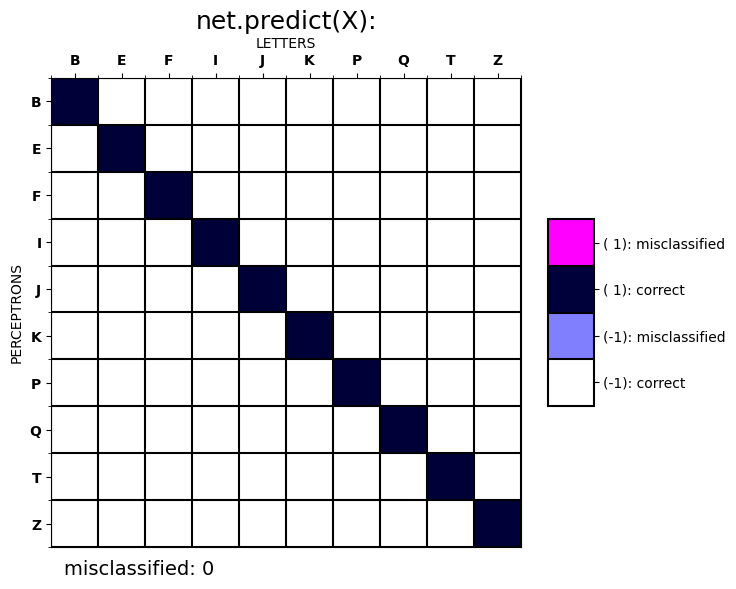

In [6]:
net.missclasificationGraph(X, y, letters, "net.predict(X):")

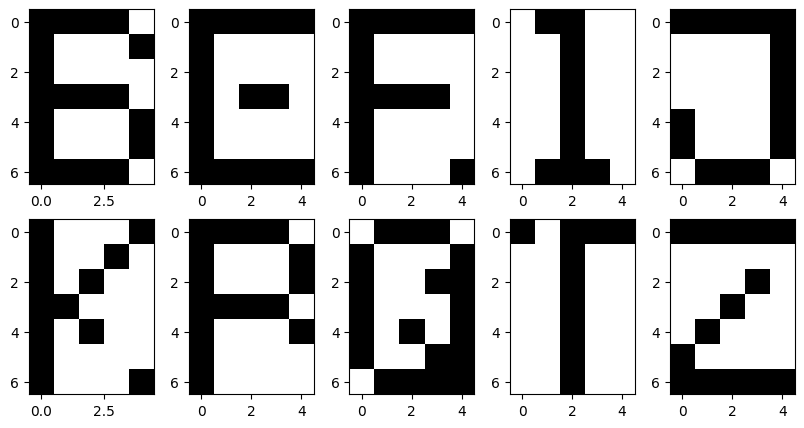

In [7]:
damage5 = SLP.damage(X, 5)
SLP.show(damage5)

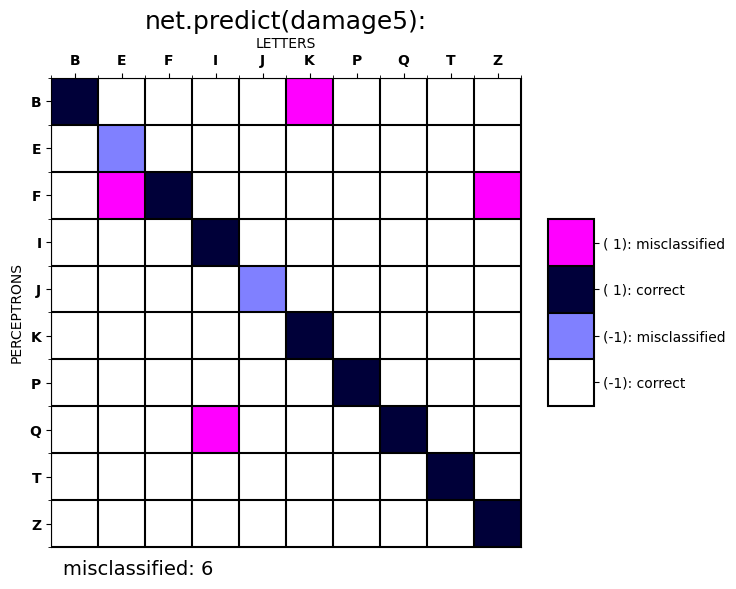

In [8]:
net.missclasificationGraph(damage5, y, letters, "net.predict(damage5):")

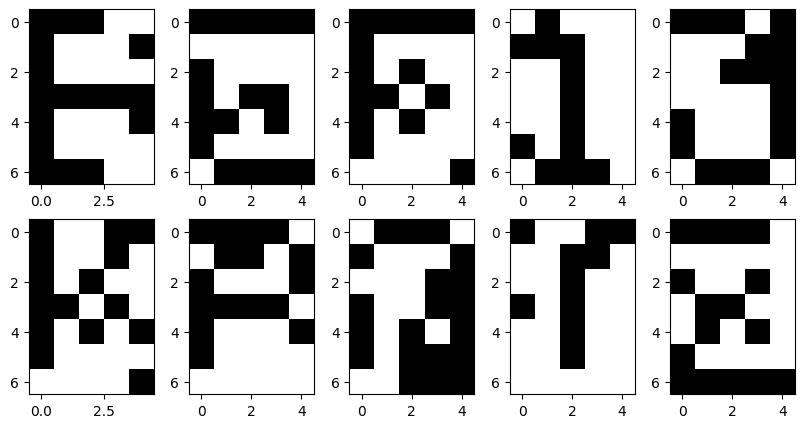

In [9]:
damage15 = SLP.damage(X, 15)
SLP.show(damage15)

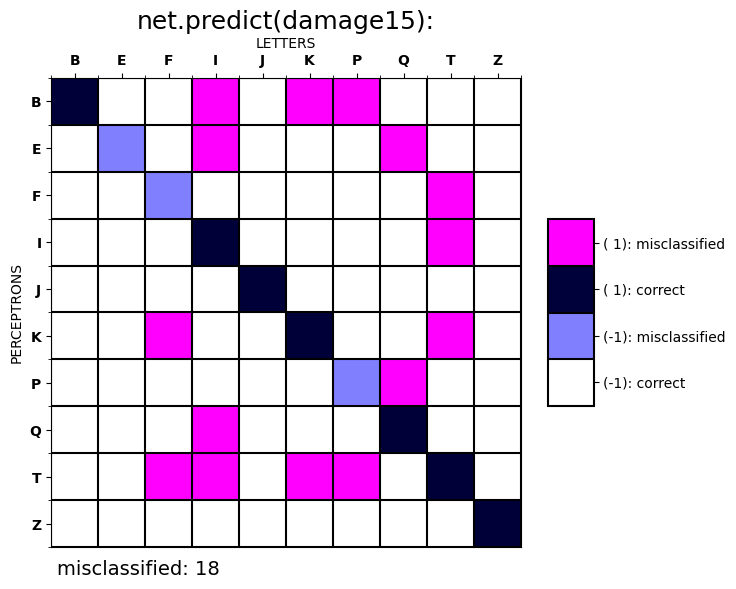

In [11]:
net.missclasificationGraph(damage15, y, letters, "net.predict(damage15):")

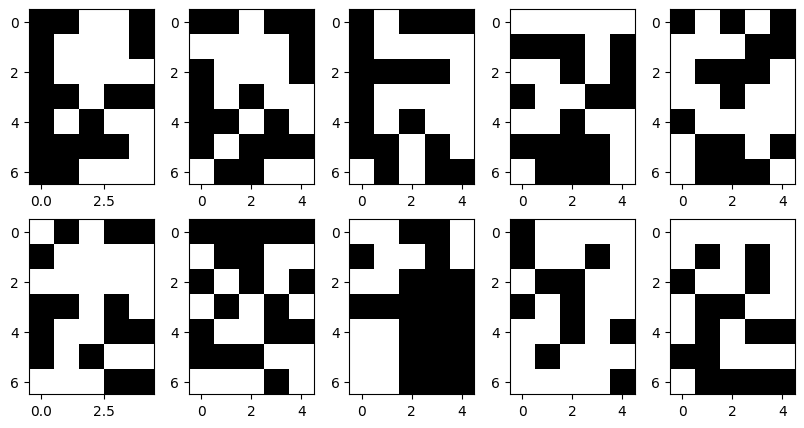

In [12]:
damage40 = SLP.damage(X, 40)
SLP.show(damage40)

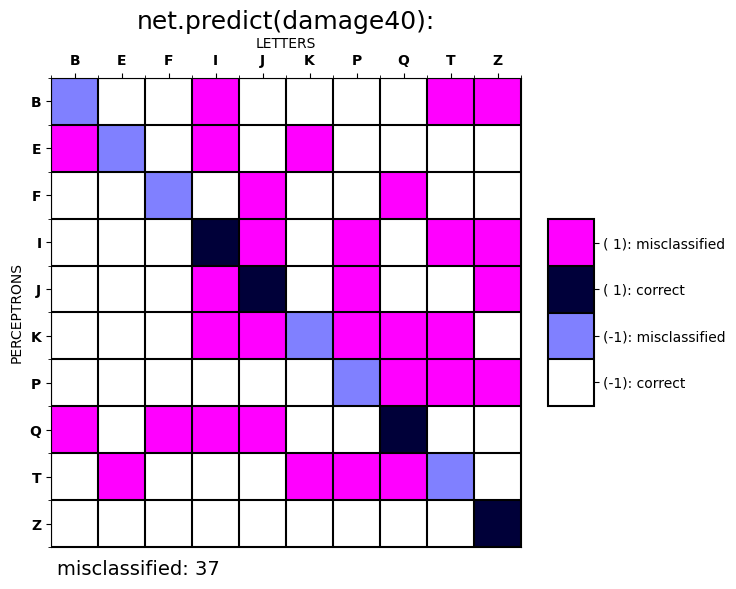

In [13]:
net.missclasificationGraph(damage40, y, letters, "net.predict(damage40):")